# The double integrator example with control loss over $\mathbb{R}⁻$

## Definition of the optimal control problem

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min T, \\[0.5em]
        \dot{x}_1(t) = x_2(t) \\
        \dot{x}_2(t) =\mathbb{1}_{\mathbb{R}⁻}(x_1(t))\lambda + (1 - \mathbb{1}_{\mathbb{R}⁻}x_1(t))  u(t),  \\[0.5em]
        \lambda,u(t) \in [-1, 1], \\[0.5em]
        x(0) = x_0,\quad x(T) = 0_{\mathrm{R}^2}.
    \end{array}
    \right.
$$

In [8]:
# For direct methods
using JuMP  # NLP modeling
using Ipopt # NLP solving
# To plot solutions
using Plots
using LaTeXStrings
using Plots.PlotMeasures

In [2]:
mutable struct Direct
    t; x1; x2 ; λ ; u ; xu ; xv ; p1 ; p2
end

In [3]:
# Parameters
t0  = 0.    # initial time
x1f = 0.    # Final position
x2f = 0.
M   = 1.0;  # control bound

In [10]:
function F(x, alpha, a)
    return 1 / (1 + exp(alpha * (x - a)))
end
fNC(x)  = F(x, 170, 0.0)
fC(x)   = 1. - F(x, 170, 0.0)

plot(fNC, -0.5, 0.5, color="red",  label="fNC", size=(400, 300));

In [11]:
function DI(x0, ε; solution=[], nsteps=500, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
                x1[1:N+1]    
                x2[1:N+1]   
        -1.0  ≤  λ[1:N+1]  ≤ 1.0
        -1.0  ≤  u[1:N+1]  ≤ 1.0
         0.0  ≤ Δt         ≤ 1.0 
        -1e1  ≤   v[1:N+1] ≤ 1e1 
         -1e1  ≤ xv[1:N+1]
         -1e1  ≤ xu[1:N+1]
    end)
    
    set_start_value(Δt, 20/N);
    for i in 1:N+1
        set_start_value(λ[i] , 1.0);
        set_start_value(v[i] , 0.0);
        set_start_value(xv[i], 0.0);
        set_start_value(xu[i], 0.0);
    end
    
    T = Δt*(N+1) ;
    
    # Objective
    @objective(sys, Min, T + ε*xv[N+1] + xu[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_xu0, xu[1]   == 0.0
        con_xv0, xv[1]   == 0.0
        con_x10, x1[1]   == x0[1] 
        con_x20, x2[1]   == x0[2] 
        con_x1f, x1[N+1] == 0.0 
        con_x2f, x2[N+1] == 0.0
        con_x30, -1. <= λ[1]    <= 1.0
        con_x3f, -1. <= λ[N+1]  <= 1.0
    end)

    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j])
    @NLexpression(sys, dx2[j = 1:N+1], fC(x1[j])*u[j] +fNC(x1[j])*λ[j])
    @NLexpression(sys,  dλ[j = 1:N+1], fC(x1[j])*v[j])
    @NLexpression(sys, dxv[j = 1:N+1], v[j]^2)
    @NLexpression(sys, dxu[j = 1:N+1], fNC(x1[j])*u[j]^2)
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N],  λ[j+1] ==  λ[j] + 0.5 * Δt * (dλ[j+1]  + dλ[j])
        con_dxv[j=1:N], xv[j+1] == xv[j] + 0.5 * Δt * (dxv[j+1] + dxv[j])
        con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])
    end)
    
    
    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    λ  = value.(λ)[:]
    u  = value.(u)[:]
    xu  = value.(xu)[:]
    xv  = value.(xv)[:]
    t  = (0:N) * value.(Δt)
    
    
    px10 =   dual(con_x10)
    px20 =   dual(con_x20)
    px1f = - dual(con_x1f)                                 # Modification : changement de signe
    px2f = - dual(con_x2f)                                 # Modification : changement de signe

    # keep original signs for now
    sign = 1
    
     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.; px1f]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions
    
     p1 = - [px10; px1[1:N-1]; px1f];                     # We add the multiplier from the limit conditions
     p2 = - [px20; px2[1:N-1]; px2f];                     # We add the multiplier from the limit conditions

    
    
    
    return Direct(t, x1, x2, λ, u, xu, xv, p1, p2)
    
    
end;

In [12]:
# Resolution
x0  = [-1.0; 0.0]

ε   = 1e-4

sol = DI(x0, ε, nsteps=500);

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    16506
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:    35000

Total number of variables............................:     3508
                     variables with only lower bounds:     1002
                variables with lower and upper bounds:     1504
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2506
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0040000e+01 1.00e+00 4.36e-01  -1.0 0.00e+00    -  0.00e+00

  (Local) solution found
  objective value = 4.473932499191194



┌ Warning: Function fNC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fNC, 1, fNC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370
┌ Warning: Function fC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fC, 1, fC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


xu = 0.05249938801911689
xv = 4.849494669910221


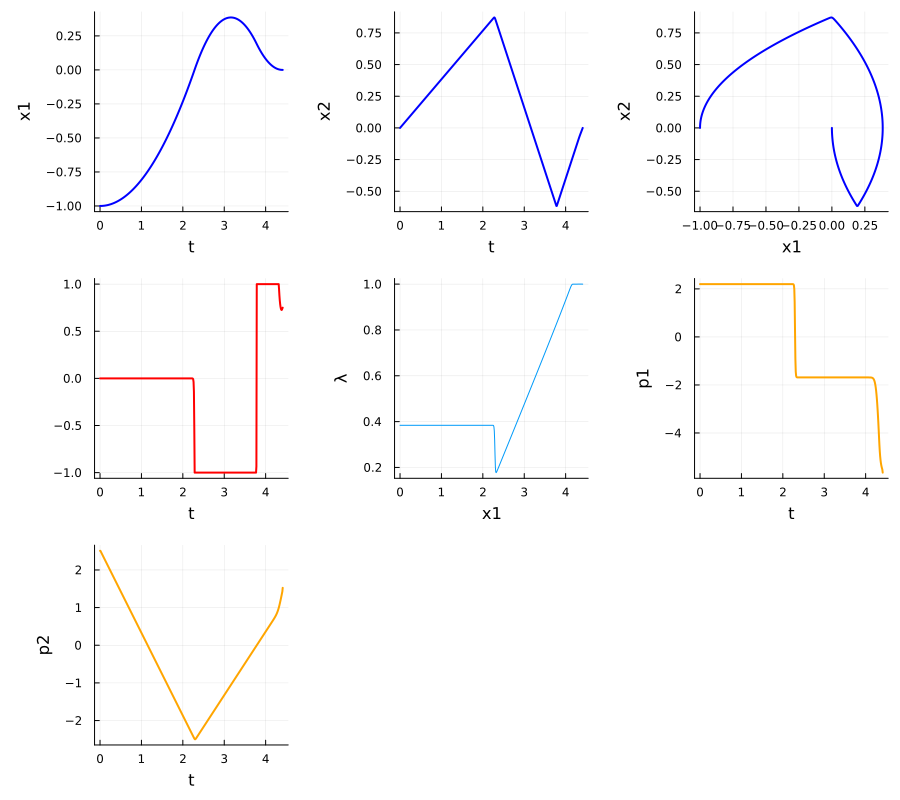

In [13]:
# Plots
t  = sol.t
x1 = sol.x1
x2 = sol.x2
λ  = sol.λ
u  = sol.u
xu = sol.xu
xv = sol.xv
p1 = sol.p1
p2 = sol.p2

println("xu = ", xu[end])
println("xv = ", xv[end])


x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  label=L"optimal trajectory ", legend = false,linecolor=:blue, linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  label=L"optimal trajectory ", legend = false,linecolor=:blue, linewidth=2)


control_plot = plot(t, u,  xlabel = "t", label = "u",legend = false, linecolor=:red , linewidth=2)

x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  label=L"optimal trajectory ", legend = false,linecolor=:blue,linewidth=2)
λ_plot = plot(t, λ, xlabel = "x1", ylabel = "λ",  legend = false)

p1_plot   = plot(t, p1,  xlabel = "t", ylabel = "p1",  legend = false,  linecolor=:orange , linewidth=2)
p2_plot   = plot(t, p2,  xlabel = "t", ylabel = "p2",  legend = false,  linecolor=:orange , linewidth=2)

plot( x1_plot,x2_plot, x1x2_plot, control_plot , λ_plot, p1_plot,p2_plot, layout = (3,3), size=(900, 800), left_margin=5mm)

In [18]:
# Compute the differences between adjacent elements
d = diff(u)

# Find the indices where the differences are non-zero
switchings = findall(abs.(d) .> 0.45)

# Print the result
switching_times = t[switchings]  

tc1    = switching_times[1]
tc2    = switching_times[2];

In [23]:
jmp1 = p1[switchings[1]+2] -p1[switchings[1]]  
jmp2 = p1[switchings[2]+2] -p1[switchings[2]] ;   

# Indirect method

In [24]:
using NLsolve
using Plots
using Plots.PlotMeasures
include("flow.jl");

In [31]:
# Dynamics
function F0(x)
    return [ x[2], 0.]
end

function F1(x)
    return [ 0.0 ,1.0]
end


H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)

# Hamiltonians: 
H(x, p, u)  =  H0(x, p) + u*H1(x,p)                             # pseudo-Hamiltonian

up(x, p) =   1.0
um(x, p) = - 1.0

Hp(x, p) = H(x, p, up(x, p))
Hm(x, p) = H(x, p, um(x, p))


# Hamiltonians: control loss region 2
H2(x, b, y, p)  = H0(x, p) + b*H1(x, p) - y*p[2]                # pseudo-Hamiltonian
Hcl(X, P)       = H2(X[1:2], X[3], X[4], P[1:2])                # control loss 2



# Flows
fp    = Flow(Hp)
fm    = Flow(Hm)
fcl   = Flow(Hcl) ;

In [37]:
t0 = 0.0
x0 = [-1.0; 0.0]

# Shooting function
function SHOOT(p0, tt1, tt2, b1, jump1, TT) 
    
    pb0    = 0.0 
    py0    = 0.0
        
    X1, P1 = fcl(t0, [x0 ; b1 ; 0.0], [p0 ; pb0 ; py0], tt1)
    
    x2, p2 = fm(tt1, X1[1:2], P1[1:2] - [jump1, 0. ], tt2)
    
    x3, p3 = fp(tt2, x2, p2, TT)
    

         s = zeros(eltype(p0), 7)
    
    s[1:2] = x3 - [ 0.0 , 0.0 ]                          # target
    s[3]   = X1[1] - 0.0                                 # first crossing 
    s[4]   = H1(x2, p2)                                  # switching
    s[5]   = jump1 - P1[2]*(-1. - b1)/(X1[2])            # jump
    s[6]   = Hp(x3, p3) - 1.0                            # free final time
    s[7]   = P1[3]                                       # averaged gradient condition 

    return s

end;

In [38]:
S(ξ) = SHOOT(ξ[1:2], ξ[3], ξ[4], ξ[5],ξ[6],ξ[7]);

In [39]:
ξ_guess = [p1[1] , p2[1], tc1, tc2, λ[div(1+switchings[1],2)], jmp1, t[end]]; # initial guess

In [40]:
S(ξ_guess)

7-element Vector{Float64}:
  -0.014914410349346771
   0.009295595246022323
  -0.005019528704245936
  -8.411246074254901
  -5.696850646940599
 -11.880118734067597
  -0.014405762779245613

In [42]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0  = indirect_sol.zero[1:2]
    tt1  = indirect_sol.zero[3]
    tt2  = indirect_sol.zero[4]
    b11  = indirect_sol.zero[5]
    jmp11 = indirect_sol.zero[6]
    T1   = indirect_sol.zero[7]

else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.188012e+01              NaN
     1     8.139171e-02     5.440099e+00
     2     7.339891e-03     1.557580e-01
     3     9.817965e-06     5.142950e-03
     4     4.914735e-10     4.102519e-05
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [2.197730240724827, 2.508065400701903, 2.276655939560703, 3.7767780702789953, 0.3839279652131526, -1.7458392511976877, 4.412123913877331]
 * Zero: [2.1973682268065855, 2.4142135621503047, 2.1973682268564714, 3.7511422009307362, 0.4142135623524524, 3.7511422003883617, 4.394736453882405]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5


In [44]:
ode_sol = fcl((t0, tt1), [x0 ; b11 ; 0.0], [pp0 ; 0. ; 0.], saveat=0.1)
ttt1    = ode_sol.t ;
xx1     = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1     = [ ode_sol[5:6, j] for j in 1:size(ttt1, 1) ] ;
uu1     = b11.*ones(length(ttt1)) ;

ode_sol = fm((tt1, tt2), xx1[end], pp1[end] - [jmp11, 0.], saveat=0.1) ;
ttt2    = ode_sol.t ;
xx2     = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ] ;
pp2     = [ ode_sol[3:4, j] for j in 1:size(ttt2, 1) ] ;
uu2     = (-1.).*ones(length(ttt2)) ;

ode_sol = fp((tt2, T1), xx2[end], pp2[end], saveat=0.1) ;
ttt3    = ode_sol.t ;
xx3     = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ] ;
pp3     = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] ;
uu3     = (1.).*ones(length(ttt3)) ;


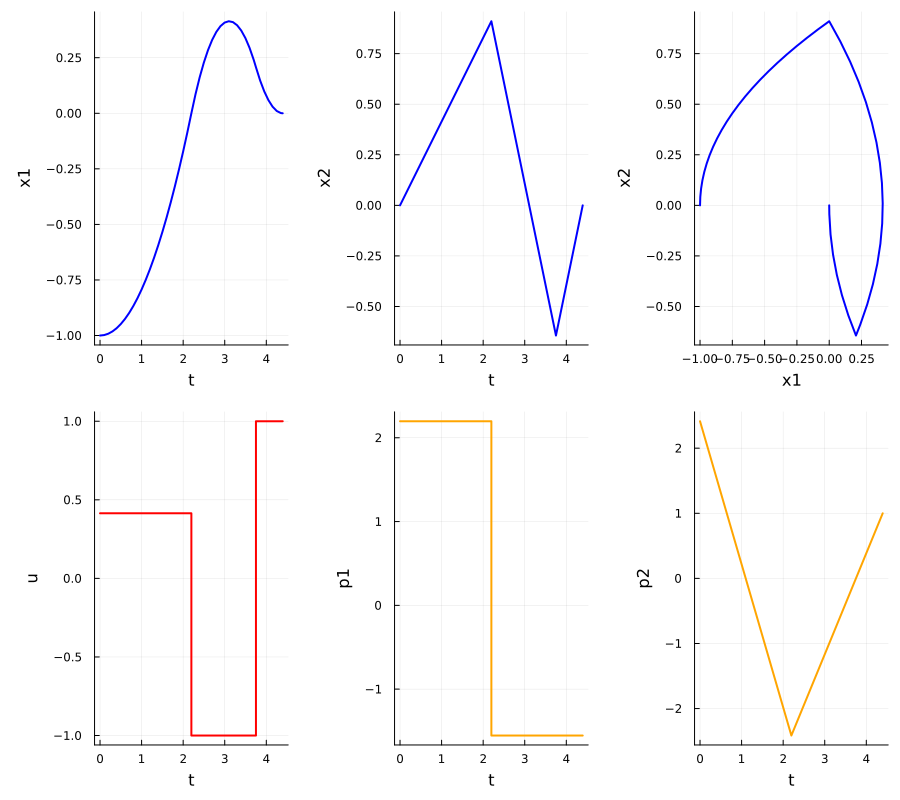

In [45]:
t = [ ttt1 ; ttt2 ; ttt3 ]
x = [ xx1 ; xx2 ; xx3  ]
p = [ pp1 ; pp2 ; pp3   ]
u = [ uu1 ; uu2 ; uu3   ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend = false,  linecolor=:blue , linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  legend = false,  linecolor=:blue , linewidth=2)

p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend = false, linecolor=:orange , linewidth=2)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", legend = false,  linecolor=:orange , linewidth=2)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",   legend = false,  linecolor=:red , linewidth=2) #, linetype=:steppre)

x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false,  linecolor=:blue , linewidth=2)

plot( x1_plot,x2_plot, x1x2_plot, u_plot , p1_plot,p2_plot, layout = (2,3), size=(900, 800), left_margin=5mm)